In [34]:
#글씨체 설정 코드
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False
font = fm.FontProperties(fname=path, size=9)
plt.rc('font', family='NanumBarunGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import os
import numpy as np
import pandas as pd
import cv2
import time
import math
import argparse
import random
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
# from transformers import AutoTokenizer
# from transformers.optimization import get_cosine_schedule_with_warmup
# from transformers import AutoModel,ViTModel,ViTFeatureExtractor

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Drive Mount

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Working Directory 설정

import os
os.chdir('/content/gdrive/Shareddrives/주제분석/data')

In [4]:
# 시드 설정

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [5]:
# 데이터 불러오기

df = pd.read_csv('final_train.csv')

## **Data augmentation 함수 정의**

In [6]:
# RD(random deletion): 텍스트의 일정 비율을 제거해주는 함수

def RD(input: list, frac: float, seed=42):
    random.seed(seed)
    text = input.split(' ')

    # 제거할 단어 수 지정
    if round(len(text) * frac) > 1:
        del_num = round(len(text) * frac)
    else:
        del_num = 1

    index = random.sample(range(len(text)), del_num)
    for i in sorted(index, reverse=True):
        del text[i]
    result = ' '.join(s for s in text)

    return result


# RS(Randon Swap): 텍스트의 일정 비율의 단어들의 순서를 바꿔줌

def RS(input: list, frac: float, seed=42):
    np.random.seed(seed)
    sentence = input.split('.')
    swap_list = []
    for s in sentence:
        text = s.split(' ')

        if len(text) == 1:
            pass
        else:
        # 위치를 바꿔줄 단어 수 지정
            if round(len(text) * frac) > 2:
                swap_num = round(len(text) * frac)
            else:
                swap_num = 2

            index = random.sample(range(len(text)), swap_num)

            for i in range(len(index) - 1):
                text[index[i]], text[index[i + 1]] = text[index[i + 1]], text[index[i]]
            sentence_result = ' '.join(s for s in text)
            swap_list.append(sentence_result)
    result = '. '.join(s for s in swap_list)

    return result

## 데이터 역전 현상: 고유값 개수 기준으로 증강할 경우 특정 값보다 조금 큰 데이터는 증강되고, 
## 특정 값보다 조금 작은 데이터는 증강되지 않아 데이터가 증강된 후 데이터의 개수가 역전되는 현상

## 따라서 "확률적으로" 접근해 데이터를 증강하였습니다

In [7]:
count_df = pd.DataFrame()
count_df = df['cat3'].value_counts().rename_axis('unique_values').reset_index(name='counts')
for i in range(count_df.shape[0]):
  count_df.counts[i] = df.shape[0] / count_df.counts[i]


root_list = []
for i in range(count_df.shape[0]):

  # 분산을 줄이기 위해 루트를 씌워주었습니다.   
  root_list.append(count_df.counts[i] ** (1/2)) 

count_df.counts = root_list


# 0~1 사이의 확률값으로 만들기위해 min-max scailing을 진행하였습니다
x_min = count_df.counts.min()
x_max = count_df.counts.max()

weight_list=[]
for i in range(count_df.shape[0]):
  weight_list.append((count_df.counts[i]-x_min)/(x_max - x_min))

count_df.counts = weight_list
df = pd.merge(df, count_df, how='left', left_on='cat3', right_on='unique_values')



# 각 관찰값에 대해 binomial distribution을 통해 0 또는 1의 값 추출 > 0이면 증강을 하지 않고 1이면 증강을 합니다.
mode_list = []
for i in range(df.shape[0]):
  mode_list.append(random.choices(range(0, 2), weights = [(1-df.counts[i]), df.counts[i]]))

mode_list = sum(mode_list, [])
df["mode"] = mode_list
df

,id,img_path,overview,cat1,cat2,cat3,unique_values,counts,mode
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구,항구/포구,0.100896,0
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프,골프,0.085411,0
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식,한식,0.000000,0
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식,한식,0.000000,0
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식,한식,0.000000,0
...,...,...,...,...,...,...,...,...,...
16960,TRAIN_16981,./image/train/TRAIN_16981.jpg,해발 12000m에 자리한 식담겸 카페점문점이다.<br>곤드레밥과 감자전을 판매하고...,음식,음식점,한식,한식,0.000000,0
16961,TRAIN_16982,./image/train/TRAIN_16982.jpg,설악힐호텔은 동해고속도로 속초톨게이트에서 멀지 않은 관광로 변에 있다. 속초의 대표...,숙박,숙박시설,모텔,모텔,0.053079,0
16962,TRAIN_16983,./image/train/TRAIN_16983.jpg,충남 서산시 중심가에 위치한 줌모텔은 프라이버스가 보장되는 조용한 공간으로 가치가 ...,숙박,숙박시설,모텔,모텔,0.053079,0
16963,TRAIN_16984,./image/train/TRAIN_16984.jpg,토토큰바위캠핑장은 경기도 가평지역 내에서도 청정지역으로 손꼽히는 지역으로 주변에 화...,레포츠,육상 레포츠,"야영장,오토캠핑장","야영장,오토캠핑장",0.012900,0


In [8]:
# "data" 데이터 프레임의 mode에 따라 데이터 증강을 합니다.

def augmentation(data):
  for i in range(data.shape[0]):
    overview = data.iloc[i, 2]

    if data.iloc[i, -1] == 1:
      rd_overview = RD(overview, 0.2)
      rs_overview = RS(overview, 0.2)

      add_data = {'id' : data.iloc[i, 0],
                  'img_path': data.iloc[i, 1],
                  'overview': rd_overview,
                  'cat1': data.iloc[i, 3],
                  'cat2': data.iloc[i, 4],
                  'cat3': data.iloc[i, 5],
                  'unique_values': data.iloc[i, 6],
                  'counts': data.iloc[i, 7],
                  'mode':data.iloc[i, 8]}
      data = data.append(add_data, ignore_index=True)

      add_data = {'id' : data.iloc[i, 0],
                  'img_path': data.iloc[i, 1],
                  'overview': rs_overview,
                  'cat1': data.iloc[i, 3],
                  'cat2': data.iloc[i, 4],
                  'cat3': data.iloc[i, 5],
                  'unique_values': data.iloc[i, 6],
                  'counts': data.iloc[i, 7],
                  'mode':data.iloc[i, 8]}
      data = data.append(add_data, ignore_index=True)

  return data

In [9]:
df = augmentation(df)
df  # 행 수가 16965에서 19348으로 늘어났습니다.

,id,img_path,overview,cat1,cat2,cat3,unique_values,counts,mode
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구,항구/포구,0.100896,0
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프,골프,0.085411,0
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식,한식,0.000000,0
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식,한식,0.000000,0
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식,한식,0.000000,0
...,...,...,...,...,...,...,...,...,...
19344,TRAIN_16939,./image/train/TRAIN_16939.jpg,되기도 30년 고양시 원도심의 주축을 담당했던 원당 시장은 작지만 알찬 시장으로 사...,쇼핑,쇼핑,상설시장,상설시장,0.064488,1
19345,TRAIN_16972,./image/train/TRAIN_16972.jpg,업소는 외국인관광 외국인만 이용이 가능하며 내국인은 이용할 수 없습니다.<br><b...,숙박,숙박시설,게스트하우스,게스트하우스,0.133585,1
19346,TRAIN_16972,./image/train/TRAIN_16972.jpg,#본 업소는 외국인관광 외국인만 도시민박업으로 이용이 가능하며 내국인은 이용할 수 ...,숙박,숙박시설,게스트하우스,게스트하우스,0.133585,1
19347,TRAIN_16979,./image/train/TRAIN_16979.jpg,* 체험으로 깨닫게 부산광역시학생교육원<br /><br />부산의 진산 금정산(해발...,레포츠,육상 레포츠,수련시설,수련시설,0.124208,1


In [10]:
df.drop(['unique_values','counts', 'mode'], axis=1, inplace = True)

## **증강 후의 데이터 라벨 분포 시각화**

In [11]:
plt.rc('font', family='NanumGothic') 

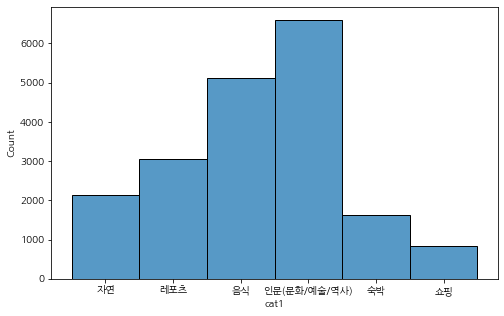

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(x = df['cat1'])

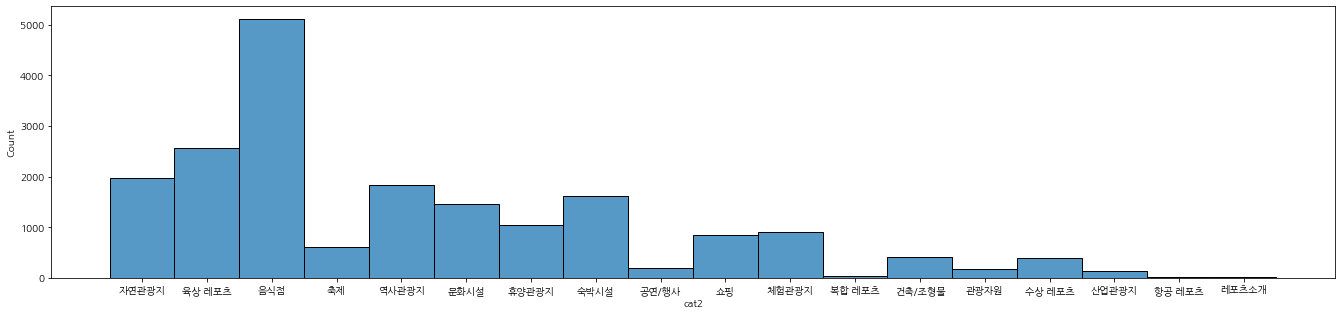

In [13]:
plt.figure(figsize=(23, 5))
#plt.ylim([0, 6000])
sns.histplot(x = df['cat2'])

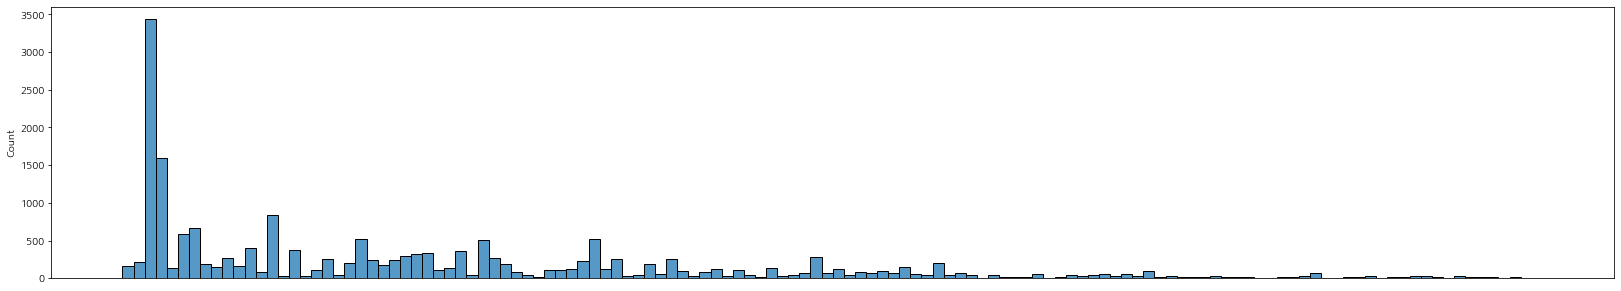

In [14]:
plt.figure(figsize=(28, 5))
sns.histplot(x = df['cat3'])
plt.gca().axes.xaxis.set_visible(False)

#    
#   
#   
## **Text 데이터 길이 분포 시각화**

In [19]:
#토큰화 함수 불러오기
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large") 

# 토큰화된 "overview" text 담을 리스트
token_list = []

for i in df.overview:
   a = tokenizer(i).get('input_ids')
   token_list.append(len(a))  #문장 별로 토큰화된 단어의 개수 'token_list' 리스트에 저장하기


df['text_length'] = token_list
df

Token indices sequence length is longer than the specified maximum sequence length for this model (1316 > 512). Running this sequence through the model will result in indexing errors


,id,img_path,overview,cat1,cat2,cat3,text_length
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구,120
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프,134
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식,83
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식,38
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:30\n\n3대에 걸쳐 아귀만을 전문으로 취급하는 ...,음식,음식점,한식,33
...,...,...,...,...,...,...,...
19344,TRAIN_16939,./image/train/TRAIN_16939.jpg,되기도 30년 고양시 원도심의 주축을 담당했던 원당 시장은 작지만 알찬 시장으로 사...,쇼핑,쇼핑,상설시장,105
19345,TRAIN_16972,./image/train/TRAIN_16972.jpg,업소는 외국인관광 외국인만 이용이 가능하며 내국인은 이용할 수 없습니다.<br><b...,숙박,숙박시설,게스트하우스,49
19346,TRAIN_16972,./image/train/TRAIN_16972.jpg,#본 업소는 외국인관광 외국인만 도시민박업으로 이용이 가능하며 내국인은 이용할 수 ...,숙박,숙박시설,게스트하우스,56
19347,TRAIN_16979,./image/train/TRAIN_16979.jpg,* 체험으로 깨닫게 부산광역시학생교육원<br /><br />부산의 진산 금정산(해발...,레포츠,육상 레포츠,수련시설,236


(0.0, 2000.0)

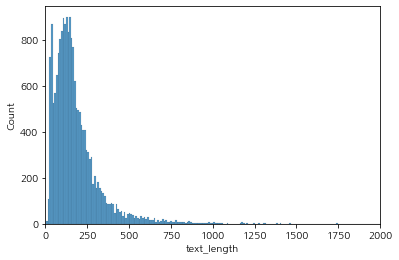

In [21]:
sns.histplot(x = df['text_length'])
plt.xlim([0, 2000]) 

# 대부분의 텍스트 데이터의 길이가 256 이하이므로 max-length는 256으로 설정할 것입니다.